### 각 사건에 영향을 주는 변수 시각화 및 전처리

In [ ]:
# kakao api를 사용한 주소 위도 경도 추출 
def getLatLng(addr):
  url = 'https://dapi.kakao.com/v2/local/search/address.json?query='+addr
  headers = {'Authorization' : 'KakaoAK 6b7945adbf5c4b11172ebb4abe552765'}
  result = json.loads(str(requests.get(url,headers=headers).text))
   
  # 주소를 제대로 변환하지 못하면 정규화 
  if result["documents"] == [] :
      new_addr = address_change(addr)
      url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + new_addr
      headers = {'Authorization' : 'KakaoAK 6b7945adbf5c4b11172ebb4abe552765'}
      result = json.loads(str(requests.get(url,headers=headers).text))

  # 주소 자체가 카카오가 없는경우 null값 처리후 자체적으로 찾거나 삭제
  if result["documents"] == [] :
    return 0, 0
  match_first = result['documents'][0]['address']
  return float(match_first['y']), float(match_first['x'])

In [ ]:
# 위도 경도 변환 함수
def wgs84_to_katec(x, y):
    inProj = Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
    outProj  = Proj("+proj=tmerc +lat_0=38 +lon_0=128 +k=0.9999 +x_0=400000 +y_0=600000 +ellps=bessel +units=m +no_defs +towgs84=-115.80,474.99,674.11,1.16,-2.31,-1.63,6.43")
    return transform(inProj, outProj, x, y)

In [ ]:
# 주소 변환 정규표현식
def address_change (addr):
  regex = r'(\w+[원,산,남,울,북,천,주,기,시,도]\s*)?' \
          r'(\w+[구,시,군]\s*)?(\w+[구,시]\s*)?' \
          r'(\w+[면,읍]\s*)' \
          r'?(\w+\d*\w*[동,리,로,길]\s*)' \
          r'?(\w*\d+-?\d*)?'
  return re.search(regex, addr)[0]

In [ ]:
# 주소 좌표 추출 함수
def grid_check (data, name, address):
    grid_list = []
    for num in range(len(data)):
        country_name = data[name][num]
        position = getLatLng(data[address][num])
        grid = wgs84_to_katec(position[1], position[0])
        grid_list.append([country_name, round(grid[0]), round(grid[1])])
    return grid_list

In [ ]:
# 각 좌표 ID(1km 이내)에 있는 공장 수를 각 GRID_ID에 총합으로 나타내기
def xy_to_ID(DF): # DF = MCHN_factory_df
  df_place = DF
  df_place["count"] = 1
  geodf = total_DF.rename(columns = {'GRID_ID' : 'id','GRID_X_AXIS':'x', 'GRID_Y_AXIS':'y'})

  # x범위: x_min 이상 X_max 이하
  geodf["x_min"] = geodf["x"] - 500
  geodf["x_max"] = geodf["x"] + 500

  # y범위: y_min 이상 y_max 이하
  geodf["y_min"] = geodf["y"] - 500
  geodf["y_max"] = geodf["y"] + 500

  # 범위에 해당하는 격자로 합치기
  df_place = df_place.conditional_join(
      geodf, 
      ('GRID_X', 'x_min', '>='), 
      ('GRID_X', 'x_max', '<='),
      ('GRID_Y', 'y_min', '>='), 
      ('GRID_Y', 'y_max', '<='),

      how = 'right'
  )
  # print(df_place.head(10)) # 장소와 격자 ID를 합친 데이터의 모습
  resul_df = df_place.groupby(['id'], as_index=False)['count'].sum()
  # print("______"*20)
  print(resul_df.sort_values(["count"], ascending=False)) # ID 위치에 존재하는 장소의 수

  return resul_df # 격자 ID 순서로 배열됨

#### 산업단지

> 가설 : 산업단지에서 기계를 작동시키거나 위험한 작업이 많으므로 크고 작은 사고가 많이 발생할 것이다. 

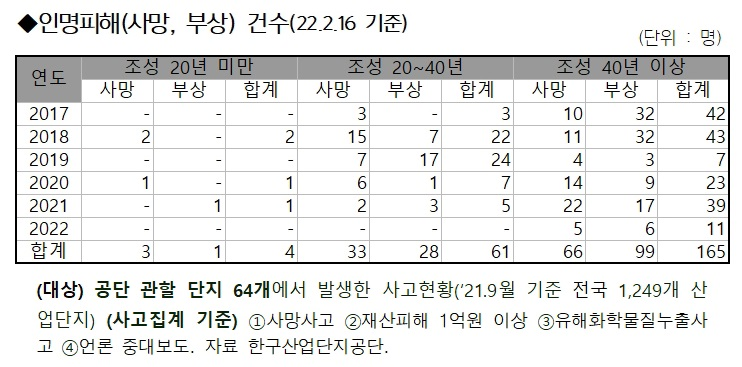

In [ ]:
# 강원도 원주시_산업단지 입주기업체 데이터 호출 (출처 : 강원도 원주시 공공데이터)
# MCHN_PATH = "/content/drive/MyDrive/Competitions/a firefighting competitions/건물정보/강원도 원주시_산업단지 입주기업체 정보_20211031.csv"
# MCHN_DF = pd.read_csv(MCHN_PATH, encoding = "cp949")

In [ ]:
# 강원도 원주시_산업단지 입주기업체 정보에서 주소값을 카카오 Api를 사용하여 위도, 경도 추출
# MCHN_list = grid_check(MCHN_DF, "업체명", "공장대표주소(지번)") 

# API 데이터를 CSV로 파일화 후 사용
# MCHN_factory_df = pd.DataFrame(MCHN_list, columns = ["업체명", "GRID_X", "GRID_Y"]).dropna()
# MCHN_factory_df.to_csv("MCHN_factory_df.csv", encoding="cp949")

# 산업단지 데이터 호출
factory_path = "/content/drive/MyDrive/Competitions/a firefighting competitions/data/factory_df.csv"
factory_df = pd.read_csv(factory_path, encoding="cp949",index_col=0)
factory_df_counted = xy_to_ID(factory_df)
factory_df_counted.rename(columns = {'id':'GRID_ID', 'count':'INDUSTRIAL_CNT'}, inplace=True) 

# 산업단지 DF Merge
data_DF = pd.merge(data_DF, factory_df_counted, on=['GRID_ID'], how='left')

         id  count
294  395533  135.0
60   383521   38.0
110  386525   34.0
44   382521   31.0
95   385525   27.0
..      ...    ...
159  389527    0.0
158  389526    0.0
157  389525    0.0
156  389524    0.0
474  418518    0.0

[475 rows x 2 columns]


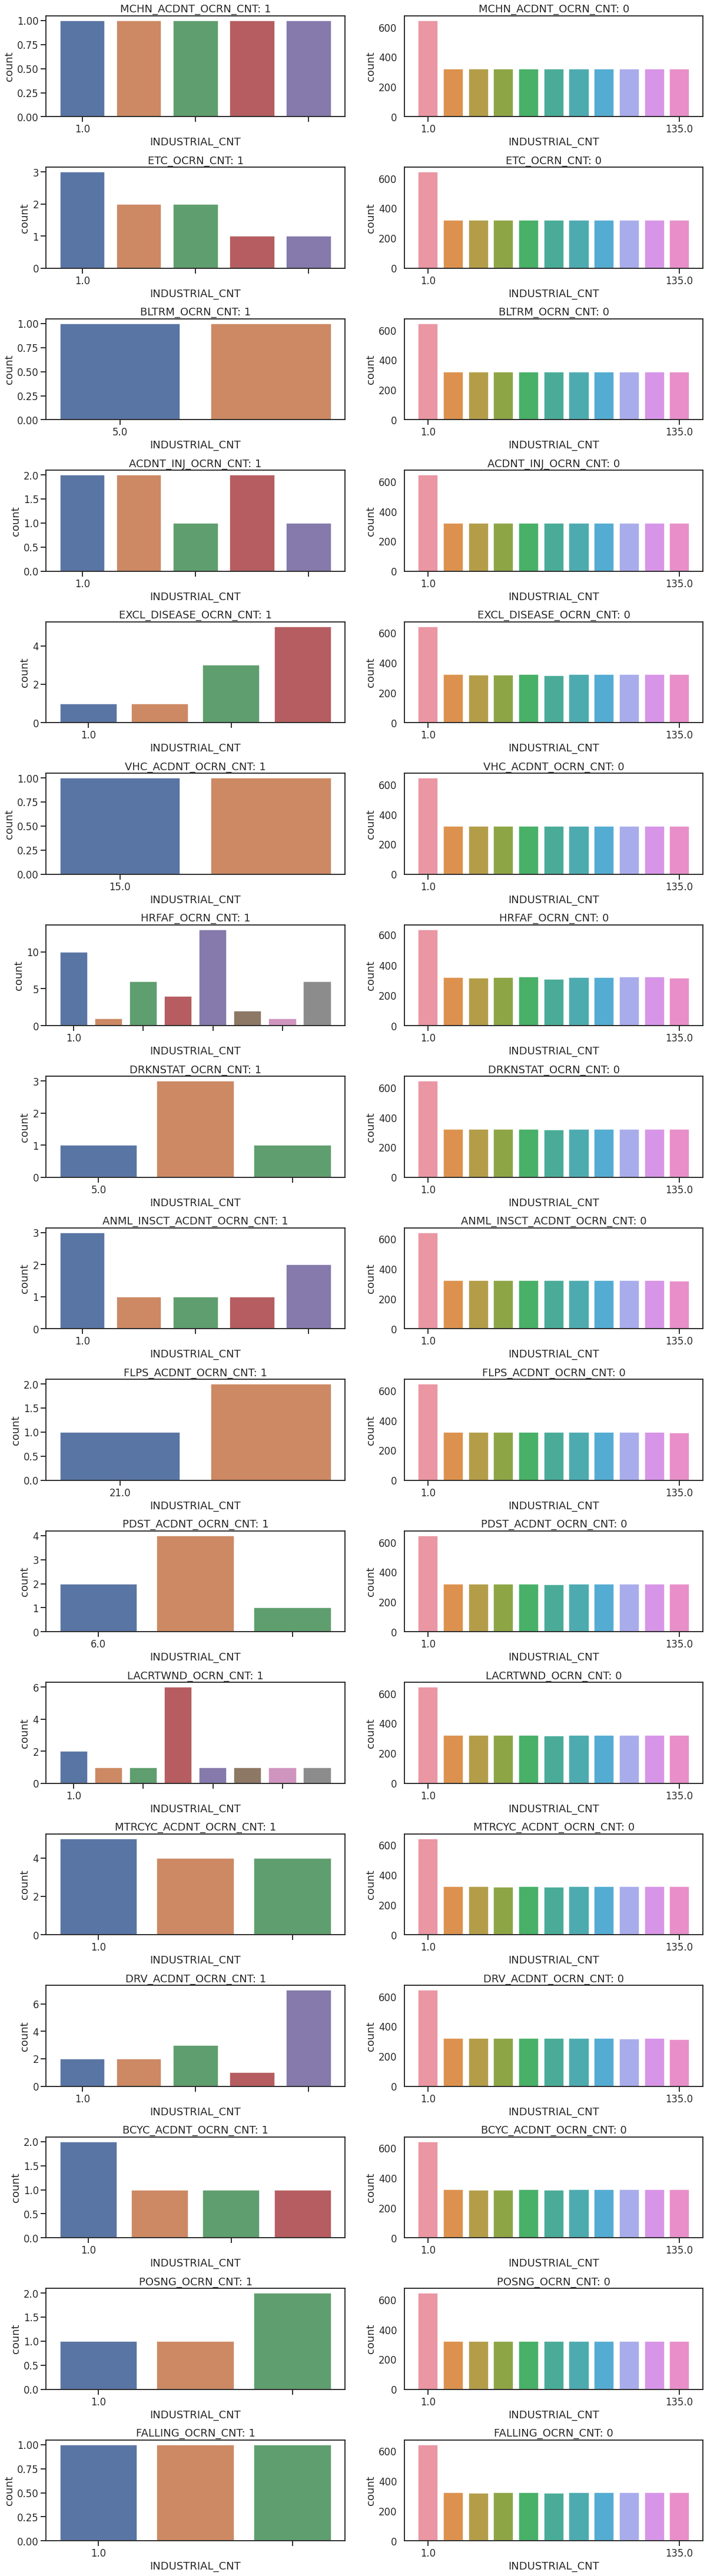

In [ ]:
# 산업단지에서의 사건 발생 유무 시각화
factory_index = data_DF.columns.get_loc("INDUSTRIAL_CNT")
plot_exc_0(factory_index)

#### 유흥가 및 단란주점

> 가설 : 술을 많이 먹은 경우 자신과 타인의 상해 위험이 증가하므로 유흥가 및 단란주점 근처에서 사고 발생이 증가될 것이다. 

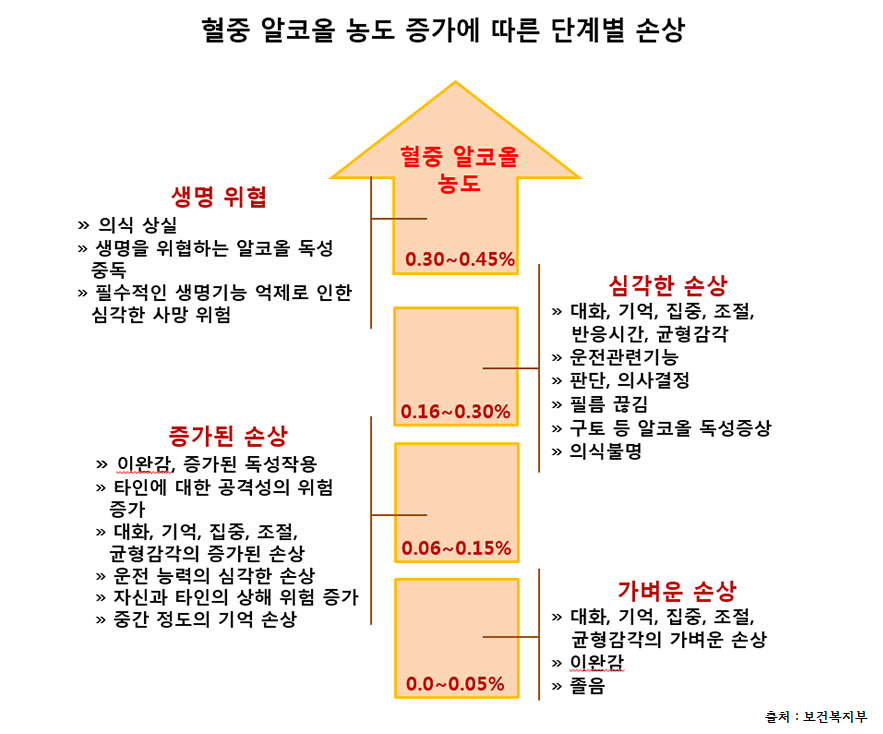

In [ ]:
# 강원도 원주시_단란주점 정보 데이터 호출 (출처 : 강원도 원주시 공공데이터)
# 2022년 이후 인허가 삭제
# KARAOKE_PATH = "/content/drive/MyDrive/Competitions/a firefighting competitions/data/강원도 원주시_단란주점 정보_20220823.csv"
# KARAOKE_Data = pd.read_csv(KARAOKE_PATH, encoding = "cp949")

# 강원도 원주시_유흥주점 정보 데이터 호출 (출처 : 강원도 원주시 공공데이터)
# 2022년 이후 인허가 삭제
# ENTERTAIN_PATH = "/content/drive/MyDrive/Competitions/a firefighting competitions/data/강원도 원주시_유흥주점정보_20221013.csv"
# ENTERTAIN_Data = pd.read_csv(ENTERTAIN_PATH, encoding = "cp949")

In [ ]:
# 단란주점 위도 경도 추출
# KARAOKE_list = grid_check(KARAOKE_Data, "업소명", "소재지(지번)") 

# 유흥주점 위도 경도 추출
# ENTERTAIN_list = grid_check(ENTERTAIN_Data, "업소명", "소재지(지번)") 

In [ ]:
# 단란주점, 유흥주점 데이터 프레임 변환 및 GRID_ID에 총합
# KARAOKE_df = pd.DataFrame(KARAOKE_list, columns = ["업체명", "GRID_X", "GRID_Y"]).dropna()
# ENTERTAIN_df = pd.DataFrame(ENTERTAIN_list, columns = ["업체명", "GRID_X", "GRID_Y"]).dropna()

In [ ]:
# 단란주점, 유흥주점 합치기 
# bar_df = pd.concat([KARAOKE_df, ENTERTAIN_df], axis=0).reset_index(drop=True)

# API 데이터를 CSV로 파일화 후 저장 후 사용
# bar_df.to_csv("bar_df.csv", encoding="cp949")

# 주점 데이터 호출
bar_path = "/content/drive/MyDrive/Competitions/a firefighting competitions/data/bar_df.csv"
bar_df = pd.read_csv(bar_path, encoding="cp949",index_col=0)
bar_df_counted = xy_to_ID(bar_df)
bar_df_counted.rename(columns = {'id':'GRID_ID', 'count':'BAR_CNT'}, inplace=True) 

# 주점 DF Merge
data_DF = pd.merge(data_DF, bar_df_counted, on=['GRID_ID'], how='left')

         id  count
267  394527   95.0
289  395528   54.0
288  395527   41.0
246  393527   32.0
303  396527   24.0
..      ...    ...
156  389524    0.0
155  389523    0.0
154  389513    0.0
153  389510    0.0
474  418518    0.0

[475 rows x 2 columns]


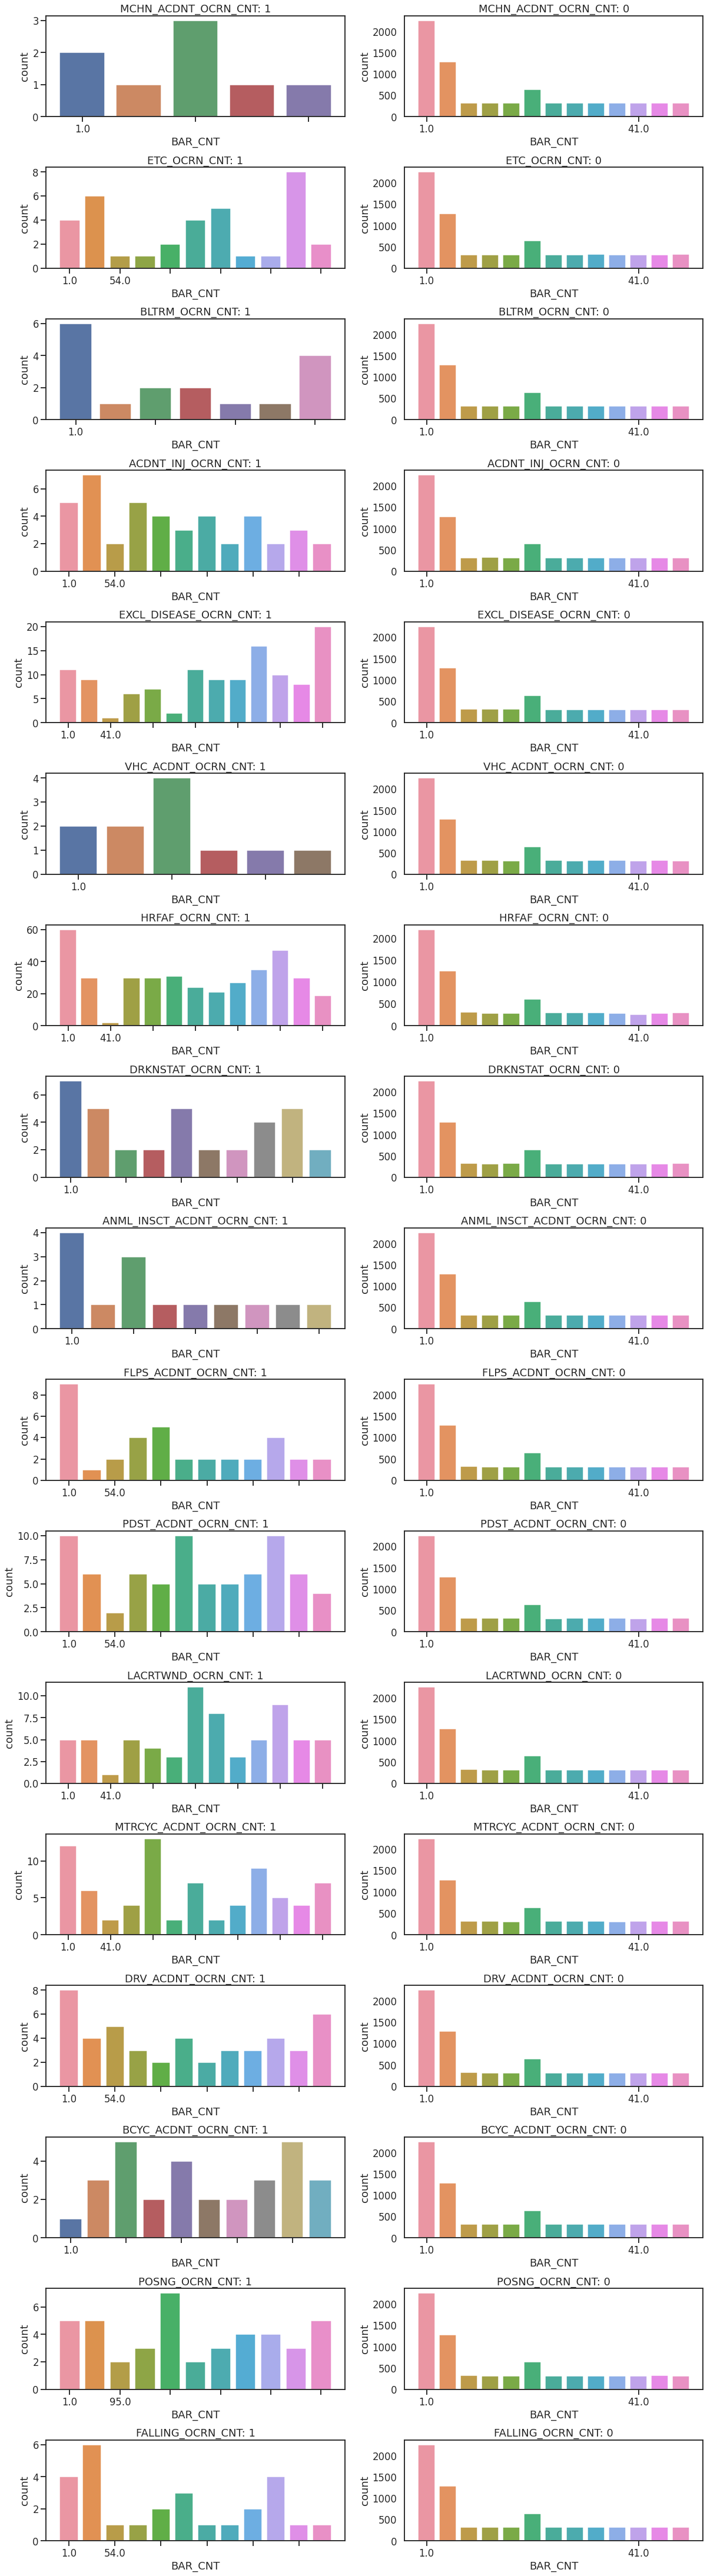

In [ ]:
# 주점에서의 사건 발생 유무 시각화
bar_index = data_DF.columns.get_loc("BAR_CNT")
plot_exc_0(bar_index)

#### 경로당

> 가설 : 경로당이 많은 지역의 경우 노인 인구가 많을 것 예상된다. 


In [ ]:
# 강원도 경로당 현황 데이터 호출 ( 출처 : 강원도 원주시청 )
# SENIOR_PATH = "/content/drive/MyDrive/Competitions/a firefighting competitions/data/경로당 현황(2021).csv"
# SENIOR_Data = pd.read_csv(SENIOR_PATH, encoding = "cp949")

In [ ]:
# 경로당 위도 경도 추출
# SENIOR_list = grid_check(SENIOR_Data, "경로당 명", "소재지")

In [ ]:
# 경로당 데이터 프레임 변환
# SENIOR_df = pd.DataFrame(SENIOR_list, columns = ["시설명", "GRID_X", "GRID_Y"]).dropna()

# API 데이터를 CSV로 파일화 후 저장 후 사용
# SENIOR_df.to_csv("senior_df.csv", encoding="cp949")

# 경로당 데이터 호출 및 GRID_ID에 총합
senior_path = "/content/drive/MyDrive/Competitions/a firefighting competitions/data/senior_df.csv"
senior_df = pd.read_csv(senior_path, encoding="cp949",index_col=0)
senior_df_counted = xy_to_ID(senior_df)
senior_df_counted.rename(columns = {'id':'GRID_ID', 'count':'SENIOR_CENTER_CNT'}, inplace=True) 

# 경로당 DF Merge
data_DF = pd.merge(data_DF, senior_df_counted, on=['GRID_ID'], how='left')

         id  count
286  395525   15.0
267  394527   12.0
268  394528   11.0
300  396524   11.0
288  395527   10.0
..      ...    ...
170  390512    0.0
169  390511    0.0
168  390508    0.0
166  389535    0.0
474  418518    0.0

[475 rows x 2 columns]


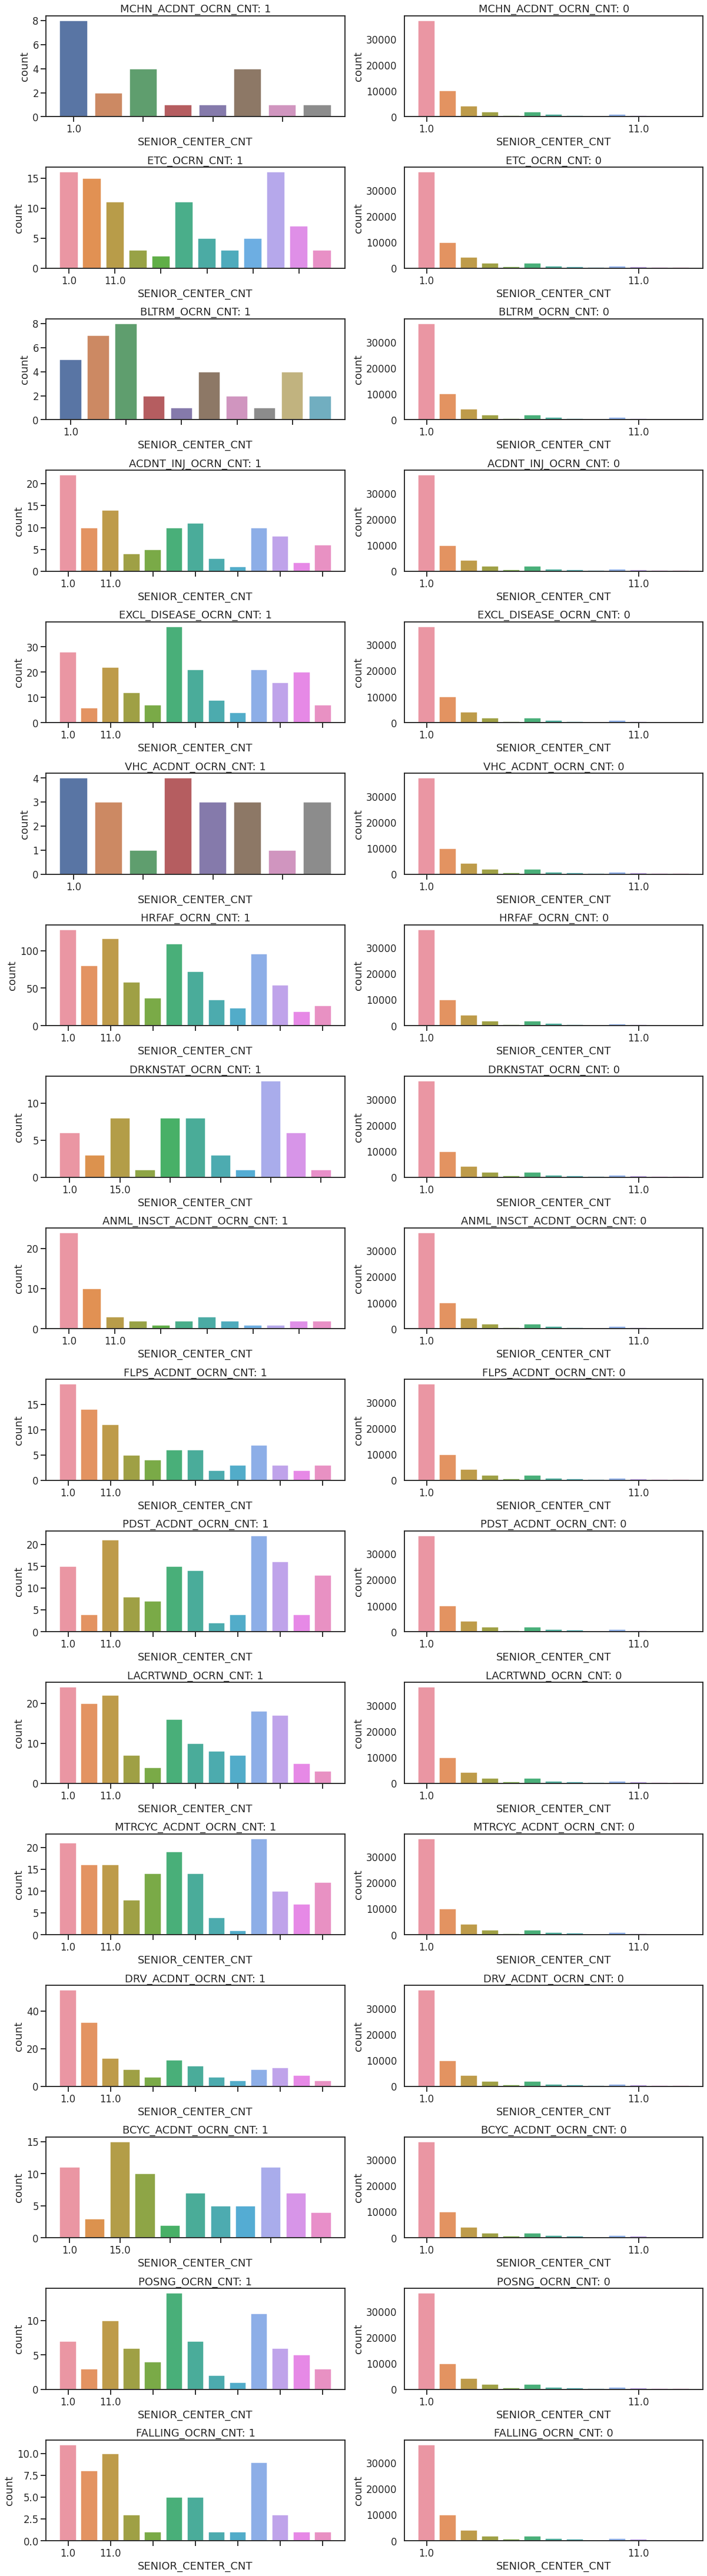

In [ ]:
# 경로당에서의 사건 발생 유무 시각화
senior_index = data_DF.columns.get_loc("SENIOR_CENTER_CNT")
plot_exc_0(senior_index)

#### 식당 

> 가설 : 식당이 많은 격자의 경우 인구가 많이 살고 있을것으로 예상된다. 

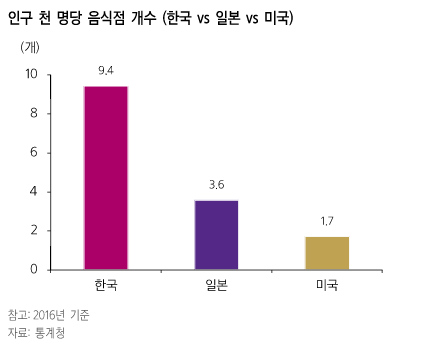

In [ ]:
# 강원도 원주시_식당기본정보 데이터 호출 ( 출처 : 강원도 원주시 공공데이터 )
# REST_PATH = "/content/drive/MyDrive/Competitions/a firefighting competitions/data/강원도 원주시_식당기본정보.csv"
# REST_Data = pd.read_csv(REST_PATH, encoding = "utf-8")

In [ ]:
# 데이터 내부에 위도경도 데이터가 존재하므로 사용
# rest_list = []
# for i in range(REST_Data.shape[0]):
#   if REST_Data.loc[i, "식당경도"] != "" and REST_Data.loc[i, "식당위도"] != "":
#     rest_grid = wgs84_to_katec(REST_Data.loc[i, "식당경도"], REST_Data.loc[i, "식당위도"])
#     rest_list.append([REST_Data.loc[i, "식당명"], round(rest_grid[0]), round(rest_grid[1])])

In [ ]:
# 식당기본정보 데이터 프레임 변환 
# restaurant_df = pd.DataFrame(rest_list, columns = ["식당명", "GRID_X", "GRID_Y"]).dropna()

# 식당기본정보 CSV로 파일화 후 저장 후 사용
# restaurant_df.to_csv("/content/drive/MyDrive/Competitions/a firefighting competitions/data/rest_df.csv")

# 식당 데이터 호출 및 GRID_ID에 총합
rest_path = "/content/drive/MyDrive/Competitions/a firefighting competitions/data/rest_df.csv"
restaurant_df = pd.read_csv(rest_path, index_col=0)
restaurant_df_counted = xy_to_ID(restaurant_df)
restaurant_df_counted.rename(columns = {'id':'GRID_ID', 'count':'RESTAURANT_CNT'}, inplace=True) 

# 식당기본정보 DF Merge
data_DF = pd.merge(data_DF, restaurant_df_counted, on=['GRID_ID'], how='left')

         id  count
267  394527  202.0
288  395527  199.0
286  395525  182.0
300  396524  178.0
246  393527  168.0
..      ...    ...
165  389533    0.0
164  389532    0.0
161  389529    0.0
160  389528    0.0
474  418518    0.0

[475 rows x 2 columns]


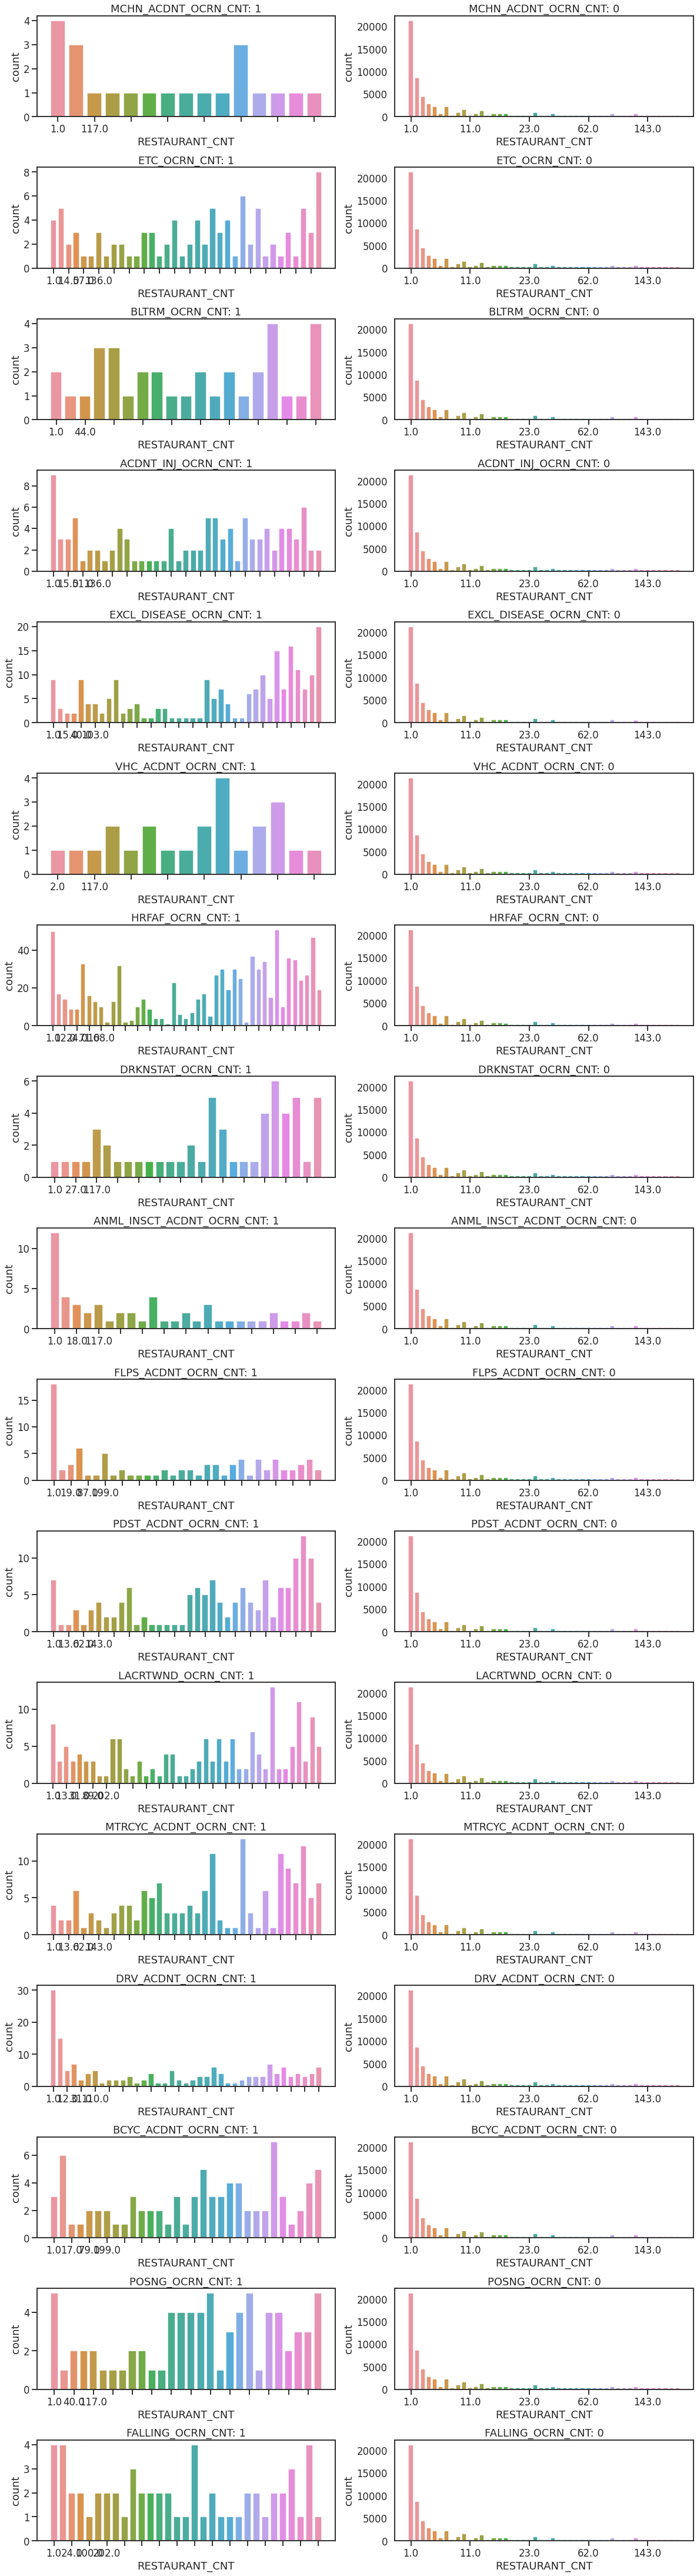

In [ ]:
# 식당기본정보에서의 사건 발생 유무 시각화
rest_index = data_DF.columns.get_loc("RESTAURANT_CNT")
plot_exc_0(rest_index)

#### 건축허가현황

> 가설 : 건설현장의 경우 추락 및 부딫힘 등의 사고 가능성이 다른곳보다 높을 것이다. 

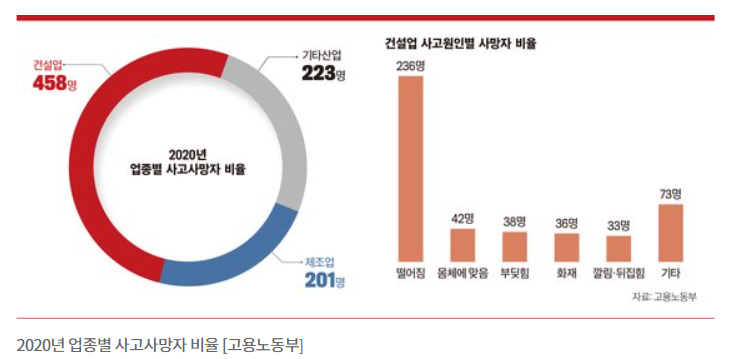

In [ ]:
# 강원도 건축허가현황조회 데이터 호출 ( 출처 : 강원도 원주시 건축허가현황 (2021.01 ~ 2021.12)
# BUILD_PATH = "/content/drive/MyDrive/Competitions/a firefighting competitions/data/건축허가현황조회.csv"
# BUILD_Data = pd.read_csv(BUILD_PATH, encoding = "cp949")

In [ ]:
# 건축대지위치 위도 경도 추출
# BUILD_list = grid_check(BUILD_Data, "허가번호", "대지위치")

In [ ]:
# 건축허가현황 데이터 프레임 변환 및 GRID_ID에 총합
# BUILD_df = pd.DataFrame(BUILD_list, columns = ["허가번호", "GRID_X", "GRID_Y"]).dropna()

# API 데이터를 CSV로 파일화 후 저장 후 사용
# BUILD_df.to_csv("/content/drive/MyDrive/Competitions/a firefighting competitions/data/build_df.csv", encoding="cp949")

# 건축허가현황 데이터 호출
build_path = "/content/drive/MyDrive/Competitions/a firefighting competitions/data/build_df.csv"
build_df = pd.read_csv(build_path, encoding="cp949",index_col=0)
build_df_counted = xy_to_ID(build_df)
build_df_counted.rename(columns = {'id':'GRID_ID', 'count':'BULID_PERMIT_CNT'}, inplace=True) 

# 건축허가현황 DF Merge
data_DF = pd.merge(data_DF, build_df_counted, on=['GRID_ID'], how='left')

         id  count
355  399524   27.0
356  399525   15.0
288  395527   14.0
162  389530   13.0
300  396524   13.0
..      ...    ...
170  390512    0.0
169  390511    0.0
168  390508    0.0
167  390507    0.0
474  418518    0.0

[475 rows x 2 columns]


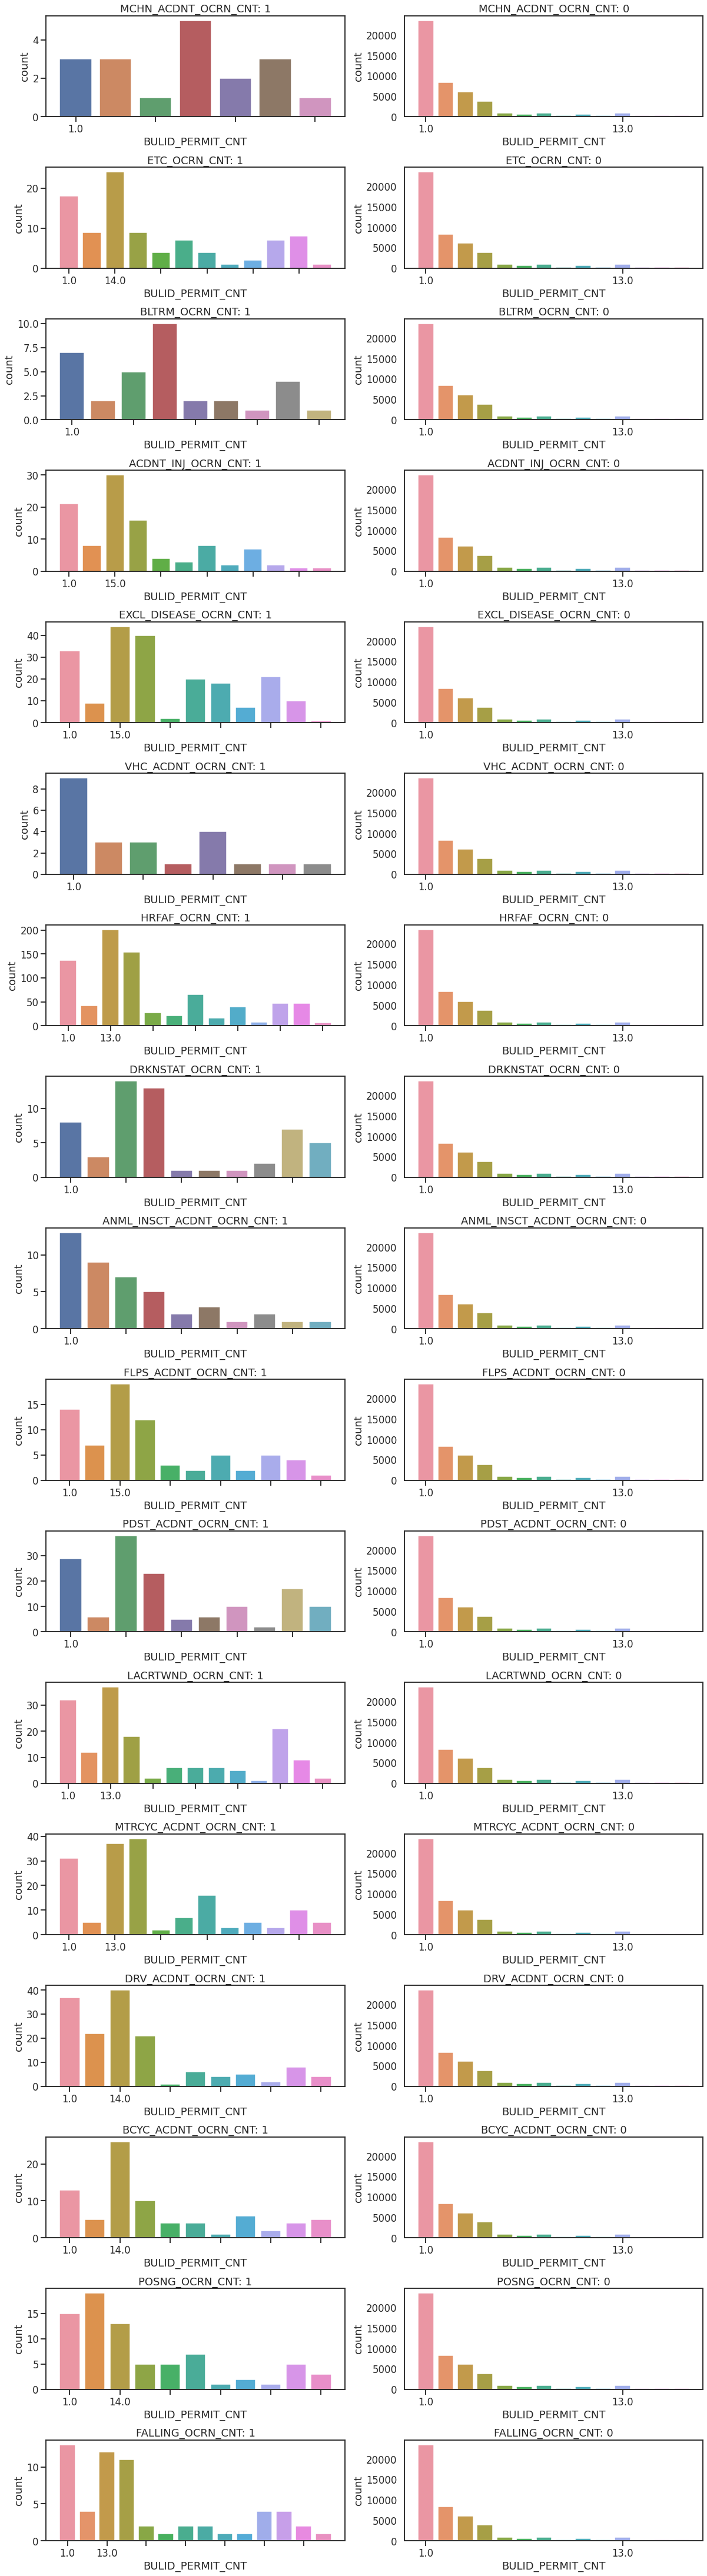

In [ ]:
# 건축허가현황에서의 사건 발생 유무 시각화
build_index = data_DF.columns.get_loc("BULID_PERMIT_CNT")
plot_exc_0(build_index)

#### 교통사고정보

> 사망사고가 발생한 격자의 경우 사고 위험성이 높을것으로 예상된다. 

In [ ]:
# 강원도 도로교통공단_사망교통사고정보(2012~2021) 데이터 호출 ( 출처 : 강원도 원주시 공공데이터 )
# ROAD_PATH = "/content/drive/MyDrive/Competitions/a firefighting competitions/data/도로교통공단_사망교통사고정보(2012~2021).csv"
# ROAD_Data = pd.read_csv(ROAD_PATH, encoding = "cp949")

In [ ]:
# 교통사고정보 데이터 내부에 위도, 경도 데이터가 존재하므로 사용
# road_list = []
# for i in range(ROAD_Data.shape[0]):
#    if ROAD_Data.loc[i, "경도"] != "" and ROAD_Data.loc[i, "위도"] != "":
#        road_grid = wgs84_to_katec(ROAD_Data.loc[i, "경도"], ROAD_Data.loc[i, "위도"])
#        road_list.append([ROAD_Data.loc[i, "발생년월일시"], round(road_grid[0]), round(road_grid[1])])

In [ ]:
# 교통사고정보 데이터 프레임 변환 
# road_df = pd.DataFrame(road_list, columns = ["식당명", "GRID_X", "GRID_Y"]).dropna()

# 교통사고정보 CSV로 파일화 후 저장 후 사용
# road_df.to_csv("/content/drive/MyDrive/Competitions/a firefighting competitions/data/road_df.csv")

# 교통사고정보 데이터 호출 및 GRID_ID에 총합
road_path = "/content/drive/MyDrive/Competitions/a firefighting competitions/data/road_df.csv"
road_df = pd.read_csv(road_path, index_col=0)
road_df_counted = xy_to_ID(road_df)
road_df_counted.rename(columns = {'id':'GRID_ID', 'count':'ACCIDENT_AREA_CNT'}, inplace=True) 

# 교통사고정보 DF Merge
data_DF = pd.merge(data_DF, road_df_counted, on=['GRID_ID'], how='left')

         id  count
286  395525   13.0
268  394528    9.0
301  396525    8.0
288  395527    8.0
292  395531    7.0
..      ...    ...
175  390524    0.0
174  390523    0.0
173  390522    0.0
172  390520    0.0
474  418518    0.0

[475 rows x 2 columns]


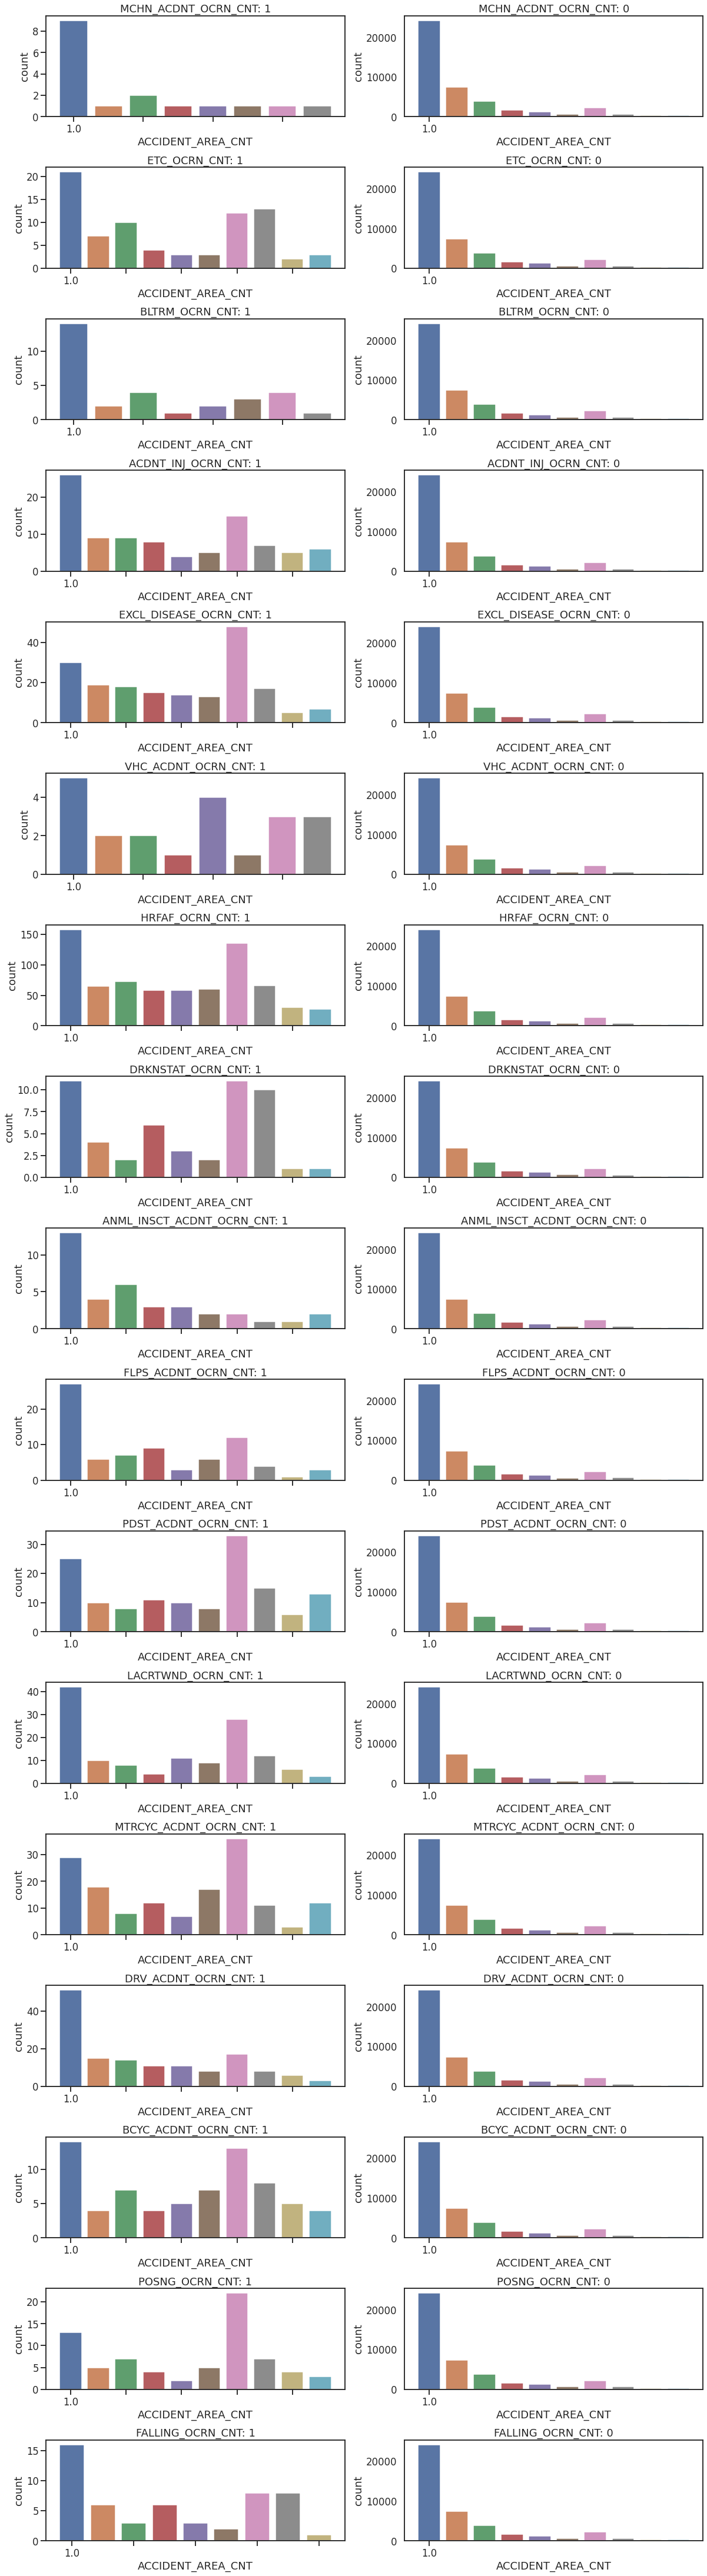

In [ ]:
# 교통사고정보에서의 사건 발생 유무 시각화
road_index = data_DF.columns.get_loc("ACCIDENT_AREA_CNT")
plot_exc_0(road_index)